In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_text as text

In [2]:
import tensorflow_hub as hub

In [3]:
import sklearn
from official.nlp import optimization  # to create AdamW optimizer

In [4]:
factoid = pd.read_pickle("/app/home/heindlc/reddit_corpus_balanced_filtered.gzip", compression = "gzip")

In [5]:
factoid["pb_factor"].isnull().sum()

74

In [6]:
factoid = factoid[~ factoid["pb_factor"].isnull()]

In [7]:
factoid["pb_factor"].isnull().sum()

0

In [8]:
data = pd.concat([pd.DataFrame([[row[1], post[1],post[3], row[-4]] for post in row[3]], columns=["user_id", "post","topic","user_pb"])
                  for row in factoid.itertuples()], ignore_index=True)


In [9]:
data.shape


(3342802, 4)

In [10]:
data.head(10)

,user_id,post,topic,user_pb
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087
1,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"he's not deteriorating, he just does not care ...",r/politics,-0.826087
2,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"Look, it's now perfectly clear that if he coul...",r/politics,-0.826087
3,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,That's the whole point of this statement. Ther...,r/politics,-0.826087
4,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"I keep seeing that M4A is now just a ""bargaini...",r/politics,-0.826087
5,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"Look, this lawsuit had to come together in a h...",r/politics,-0.826087
6,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"and yet, the top comment in a conservative sub...",r/politics,-0.826087
7,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,he definitely believes it. I don't know why pe...,r/politics,-0.826087
8,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,even in a world where Mueller comes out and sa...,r/politics,-0.826087
9,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,notice there's not one word there about any th...,r/politics,-0.826087


In [11]:
import re 
import string 

def clean_text(text):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'&gt\S+', '', text)
    text = re.sub(" \d+", " ", text) # remove numbers 
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    
    return text



In [12]:
data["post"] = data["post"].apply(clean_text)

In [13]:
#atas = df.drop(df[df.score < 400].index)
#data["post_len"] = data[len(data["post"]) > 400]

data = data[data['post'].map(len) > 300]

In [14]:
data.head(10)

,user_id,post,topic,user_pb
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087
1,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"he's not deteriorating, he just does not care ...",r/politics,-0.826087
3,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,That's the whole point of this statement. Ther...,r/politics,-0.826087
4,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"I keep seeing that M4A is now just a ""bargaini...",r/politics,-0.826087
6,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"and yet, the top comment in a conservative sub...",r/politics,-0.826087
7,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,he definitely believes it. I don't know why pe...,r/politics,-0.826087
12,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,might actually be Christ coming back for a se...,r/politics,-0.826087
14,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,throughout the entire past years there really ...,r/politics,-0.826087
15,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,**my highest ever upvoted reddit comment years...,r/politics,-0.826087
16,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,it's crazy how decentralized this country is. ...,r/politics,-0.826087


In [15]:
for index, row in data.head(10).iterrows():
    print(len(row["post"]))

364
2023
955
1597
527
1083
395
322
1889
1521


In [16]:
data_cats = data.copy()
data_cats["pb_categories"] = pd.cut(data_cats["user_pb"],
       [-3,-1.5,0,1.5,3], include_lowest=True,labels=["EXTREME_LEFT", "LEFT_CENTER","RIGHT_CENTER","EXTREME_RIGHT"])
data_cats

,user_id,post,topic,user_pb,pb_categories
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087,LEFT_CENTER
1,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"he's not deteriorating, he just does not care ...",r/politics,-0.826087,LEFT_CENTER
3,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,That's the whole point of this statement. Ther...,r/politics,-0.826087,LEFT_CENTER
4,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"I keep seeing that M4A is now just a ""bargaini...",r/politics,-0.826087,LEFT_CENTER
6,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"and yet, the top comment in a conservative sub...",r/politics,-0.826087,LEFT_CENTER
...,...,...,...,...,...
3342776,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,You don't elect a wannabe dictator to the whit...,r/politics,-0.777778,LEFT_CENTER
3342780,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,I am worried about that image being turned aro...,r/politics,-0.777778,LEFT_CENTER
3342783,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,They don't know how to win elections (and ther...,r/politics,-0.777778,LEFT_CENTER
3342800,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,Obviously this is why we need a federal level ...,r/Coronavirus,-0.777778,LEFT_CENTER


/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_categories', ylabel='count'>

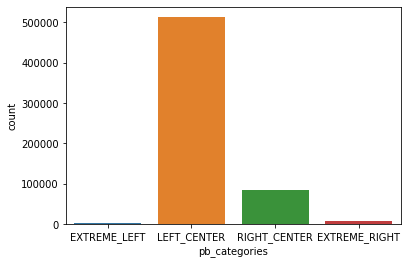

In [17]:
sns.countplot('pb_categories', data=data_cats)

In [18]:
class_counts = data_cats.pb_categories.value_counts()

c4 = data_cats[data_cats['pb_categories'] == "LEFT_CENTER"]
c3 = data_cats[data_cats['pb_categories'] == "RIGHT_CENTER"]
c2 = data_cats[data_cats['pb_categories'] == "EXTREME_LEFT"]
c1 = data_cats[data_cats['pb_categories'] == "EXTREME_RIGHT"]

In [19]:
class_counts

LEFT_CENTER      513040
RIGHT_CENTER      83984
EXTREME_RIGHT      8254
EXTREME_LEFT       2010
Name: pb_categories, dtype: int64

In [20]:
c3 = c3.sample(class_counts["EXTREME_RIGHT"])   
c4 = c4.sample(class_counts["EXTREME_LEFT"])
data_balanced = pd.concat([c1,c2,c3,c4],axis=0 )

/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_categories', ylabel='count'>

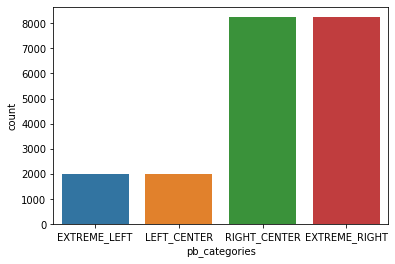

In [21]:
sns.countplot('pb_categories', data=data_balanced)

In [22]:
def binaryfy(label):
    if label in ["EXTREME_LEFT","EXTREME_RIGHT"]:
        return 1
    else: 
        return 0

In [23]:
data_binary = data_balanced.copy()
#df["Labels"] = df["Score"].apply(lambda score: map_score(score))
data_binary["pb_binary"] = data_binary["pb_categories"].apply(lambda label: binaryfy(label))

/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_binary', ylabel='count'>

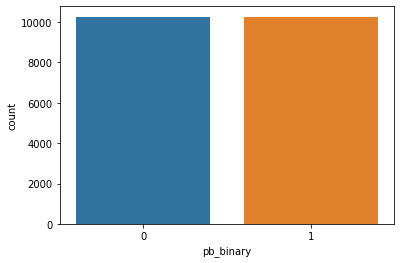

In [24]:
sns.countplot('pb_binary', data=data_binary)

In [25]:
class_counts = data_binary.pb_binary.value_counts()
print(class_counts)

1    10264
0    10264
Name: pb_binary, dtype: int64


In [26]:
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [27]:
! python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

/bin/bash: /app/home/heindlc/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [28]:
data_binary.head(3)

,user_id,post,topic,user_pb,pb_categories,pb_binary
61445,a76ed6c4f319b018700503a50c333028384bf7e9976796...,I guess hackers have gained access to the US e...,r/Republican,3.000000,EXTREME_RIGHT,1
61455,a76ed6c4f319b018700503a50c333028384bf7e9976796...,Imagine all the corruption we don’t know about...,r/Republican,3.000000,EXTREME_RIGHT,1
75069,52a047dce52a2391d1987480a20159889826f2cc2eccbd...,no! Why did it not survive a GOP governor and...,r/Conservative,1.666667,EXTREME_RIGHT,1


In [29]:
tf_data = data_binary[["post", "pb_binary"]]

In [30]:
#tf_data = tf.convert_to_tensor(tf_data)


In [31]:
tf_data_0 = tf_data[tf_data["pb_binary"]==0]
tf_data_1 = tf_data[tf_data["pb_binary"]==1]


In [32]:
tf_data_1

,post,pb_binary
61445,I guess hackers have gained access to the US e...,1
61455,Imagine all the corruption we don’t know about...,1
75069,no! Why did it not survive a GOP governor and...,1
75078,1) not every lab uses the same cycle threshold...,1
75083,What pandemic? OHHHHH thaaaaat pandemic... the...,1
...,...,...
3126758,Not arguable - there is no contention about th...,1
3126759,"I agree, but will add this. I believe that Mue...",1
3126764,"According to Rachel Maddow, Trump demanding di...",1
3126770,July th - Trump &amp; first wife ( - a Czech c...,1


In [33]:
class_counts = tf_data_1.pb_binary.value_counts()
print(class_counts)

1    10264
Name: pb_binary, dtype: int64


In [34]:
from toolz import interleave

In [35]:
tf_data = pd.DataFrame(interleave([tf_data_0.values, tf_data_1.values]))

In [36]:
tf_data

,0,1
0,I disagree strongly. One advantage the Republi...,0
1,I guess hackers have gained access to the US e...,1
2,know it’s small potatoes compared to everythi...,0
3,Imagine all the corruption we don’t know about...,1
4,The headline also noted the implication of th...,0
...,...,...
20523,"According to Rachel Maddow, Trump demanding di...",1
20524,This is what I was talking about — this infowa...,0
20525,July th - Trump &amp; first wife ( - a Czech c...,1
20526,"Wait, what? Are you saying that if an American...",0


In [37]:
tf_data = tf_data.rename(columns={0:"post",1:"pb_binary"})

## Convert to TensorFlow Dataset

In [38]:
#tf_data = data_binary[["post", "pb_binary"]]
target = tf_data.pop("pb_binary")

#target = data_binary["pb_binary"]

#Post,labels = list(train["post"]), list(train.pop("pb_binary"))
#dataset = tf.data.Dataset.from_tensor_slices(Post, labels)



In [39]:
tf_data

,post
0,I disagree strongly. One advantage the Republi...
1,I guess hackers have gained access to the US e...
2,know it’s small potatoes compared to everythi...
3,Imagine all the corruption we don’t know about...
4,The headline also noted the implication of th...
...,...
20523,"According to Rachel Maddow, Trump demanding di..."
20524,This is what I was talking about — this infowa...
20525,July th - Trump &amp; first wife ( - a Czech c...
20526,"Wait, what? Are you saying that if an American..."


In [40]:
target

0        0
1        1
2        0
3        1
4        0
        ..
20523    1
20524    0
20525    1
20526    0
20527    1
Name: pb_binary, Length: 20528, dtype: int64

In [41]:
target = np.asarray(target).astype('int32').reshape((-1,1))

In [42]:
target

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [43]:
tf_data

,post
0,I disagree strongly. One advantage the Republi...
1,I guess hackers have gained access to the US e...
2,know it’s small potatoes compared to everythi...
3,Imagine all the corruption we don’t know about...
4,The headline also noted the implication of th...
...,...
20523,"According to Rachel Maddow, Trump demanding di..."
20524,This is what I was talking about — this infowa...
20525,July th - Trump &amp; first wife ( - a Czech c...
20526,"Wait, what? Are you saying that if an American..."


In [44]:
dataset = tf.data.Dataset.from_tensor_slices((tf_data.values, target))


2022-05-29 18:08:35.146259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 18:08:36.966325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38418 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-05-29 18:08:36.968306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38418 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:61:00.0, compute capability: 8.0
2022-05-29 18:08:36.970153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [45]:
for item in dataset.take(3):
    print(item)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"I disagree strongly. One advantage the Republicans have over the Democrats is extreme loyalty and solidity on their issues. OTOH, usually there's a gaggle of centrist Democrats who are happy to vote with Republicans when the need arises. We need to call these fuckers out, primary them, and get them out of office. If we need to make an example of some of them to set the tone, that's a good thing."],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'I guess hackers have gained access to the US election. Don\xe2\x80\x99t worry though CISA is on top of it! CISA is another tech company ran by a former Microsoft executive. Microsoft has a new election system software package called ElectionGuard. Imagine that, leftist progressive tech companies have the election under control to stop \xe2\x80\x9cthe hackers\xe2\x80\x9d. Ridiculous.'],
      dt

## Split Dataset

In [46]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20528):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [47]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, len(dataset))

In [48]:
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

In [49]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder_loaded = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)

In [50]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  # shape definition ? () = none ?
    preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encoder_loaded, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [51]:
text_test = data["post"][1:2]
text_test

1    he's not deteriorating, he just does not care ...
Name: post, dtype: object

In [52]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.35802212]], shape=(1, 1), dtype=float32)


2022-05-29 18:08:48.322521: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [53]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [54]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [55]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/2
16422/16422 [==============================] - 720s 43ms/step - loss: 1.0111 - binary_accuracy: 0.5017 - val_loss: 0.7196 - val_binary_accuracy: 0.5044
Epoch 2/2
16167/16422 [============================>.] - ETA: 10s - loss: 1.0715 - binary_accuracy: 0.4977

In [ ]:
history


In [ ]:
classifier_model.predict()

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
classifier_model.save("./factoid_bert_small", include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load("./factoid_bert")

In [ ]:
examples = [len(test_ds)]

for item in test_ds:
    examples.append(str(item[0].numpy()[0]))
   

In [ ]:
examples = [
    "My German countrymen, men and women, (long pause) Changes of Government have occurred frequently in history, and in the history of our people. It is certain, however, that never was a change of Government attended with such far-reaching results as that eight years ago. At that time the situation of the Reich was desperate. We were called upon to take over the leadership of the nation at a moment when it did not seem to develop towards a great rise. We were given power in circumstances of the greatest conceivable pressure, the pressure of the knowledge that, by itself, everything was lost, and that, in the eyes of the noblest minds, this represented a last attempt, while in the eyes of evil-wishers it should condemn the National-Socialist Movement to final failure. Unless the German nation could be saved, by a miracle, the situation was bound to end in disaster. For during a period of 15 years, events had moved downwards without respite. On the other hand, this situation was only the result of the World War: of the outcome of the World War, of our own internal, political, moral, and military collapse. For these reasons it is particularly important on a day like this to think back to the course of that entire national misfortune.What was the cause of the World War? I do not want to explain it from the personal aspect, about which so many treatises have been written. Ordered by the present President Roosevelt, American scholars have investigated the cause of the World War and made sure that there could be no German guilt. In moments of so great importance in contemporary history, individuals can play a significant part only if they enter the scene as really outstanding personalities. This was not then the case. Neither on the German nor on the other side were there personalities cast in an unusual mould. The cause, therefore, could not be due to the failure or to the will of individuals. The reasons went deeper. The German form of government, certainly, could not have been the cause of that war, for Germany was a democracy already-and what a democracy! Strictly copied from the western countries, it was compromise between monarchy and parliamentary leadership. On account of its form of government then, this State could certainly not be the cause of the war waged by the democracies against the Reich as it was then. Germany, considered as a political factor in the world, was much more of a cause, for after centuries of disruption and ensuing weakness, the German tribes and states had at last combined into a new State which naturally introduced a new element into the so-called Balance of Power, an element which was regarded as an alien body by others. Even more potent, perhaps was dislike of the Reich as an economic factor. After Germany had tried for centuries to remedy her economic distress by letting people gradually starve or forcing them to emigrate, the increasing consolidation of the, political power of the Reich gave rise to a development of economic power. Germany began to export commodities rather than men, thereby securing the necessary markets in the world, a process, natural and just from our point of view, but others regarded it as encroachment into their most sacred domains.Here we come to the State which regarded this encroachment as intolerable-England.Three hundred years earlier England had gradually built her Empire, not perhaps through the free will or the unanimous demonstrations of those affected, but for 300 years this World Empire was welded together solely by force. War followed war. One nation after another was robbed of its freedom-one state after another was shattered so that the structure which calls itself the British Empire might arise. Democracy was nothing but a mask covering subjugation and the oppression of nations and individuals. This State cannot allow its members to vote if today, after they have been worked upon for centuries, they should freely choose to be members of this Commonwealth. On the contrary, Egyptian Nationalists, Indian Nationalists in their thousands are filling the prisons. Concentration camps were not invented in Germany; it is the English who were the ingenious inventors of this idea. By these means they contrived to break the backbone of other nations, to remove their resistance, to wear them down, and make them prepared at last to submit to this British yoke of democracy."
]

In [ ]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()




reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)